<!-- # **Import Libraries** -->

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from mlflow.tracking import MlflowClient

import mlflow
import mlflow.sklearn
import warnings

warnings.filterwarnings('ignore')

<!-- # **Load Dataset** -->

In [68]:
DATASET_TRAIN_PATH = r"..\data\train.csv"
DATASET_TEST_PATH = r"..\data\test.csv"

In [69]:
# Load the data
df_train = pd.read_csv(DATASET_TRAIN_PATH)
df_test = pd.read_csv(DATASET_TEST_PATH)

<!-- # **EDA** -->

In [70]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [71]:
def drop_irrelevant_features(df):
    df = df.copy()
    df = df.drop(columns="Id")
    return df

df_train = drop_irrelevant_features(df_train)
df_test = drop_irrelevant_features(df_test)

In [72]:
# Features contain nan values.
def check_nan(df):
    return df[df.columns[df.isna().any()]].columns

df_train_nan_cols = check_nan(df_train)
df_test_nan_cols = check_nan(df_test)

In [ ]:
# null_counts = df_train.isna().sum()
# if null_counts.any():
#     print(f"Found null values: {null_counts[null_counts > 0]}")

Found null values: LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


In [73]:
def missing_values_handling(df, nan_cols):
    df = df.copy()

    # Missing means doesnt have.
    cols_fill_none = [
        'Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
        'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 
        'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'
    ]
    for col in cols_fill_none:
        if col in df.columns:
            df[col] = df[col].fillna("N/A")
    # for col in nan_cols:
    #     if col in ["Alley","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1", 
    #                "BsmtFinType2","FireplaceQu", "GarageType","GarageFinish", 
    #                "GarageQual","GarageCond","PoolQC","Fence","MiscFeature","MasVnrType"]:
    #         df[col] = df[col].fillna("N/A")

    if 'LotFrontage' in nan_cols:
        df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(
            lambda x: x.fillna(x.median())
        )

    cols_fill_zero = [
        'MasVnrArea', 'GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
        'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea'
    ]
    for col in cols_fill_zero:
        if col in df.columns:
            df[col] = df[col].fillna(0)
    # if "MasVnrArea" in nan_cols:
    #     df["MasVnrArea"] = df["MasVnrArea"].fillna(0)

    # for col in nan_cols:
    #     if col in ["GarageYrBlt", 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
    #                'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea']:
    #         df[col] = df[col].fillna(df[col].median())

    # Missing drop rows.
    for col in nan_cols:
        if col in ["Electrical"]:
            df = df[df[col].notna()]

    return df

df_train = missing_values_handling(df_train, df_train_nan_cols)
df_test = missing_values_handling(df_test, df_test_nan_cols)

In [74]:
def split_feature_target(df):
    df = df.copy()
    X = df.drop(columns=['SalePrice'])
    y = df['SalePrice']
    return X, y

X_train, y_train = split_feature_target(df_train)
X_test = df_test  # No y_test.

In [75]:
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()

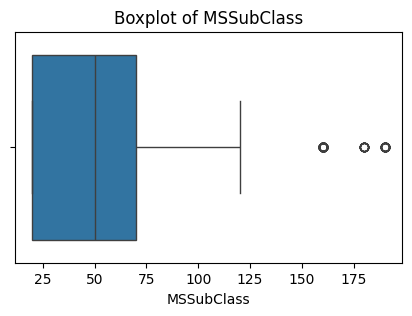

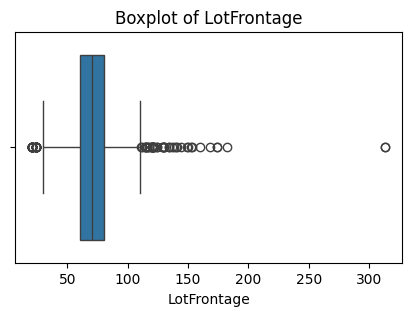

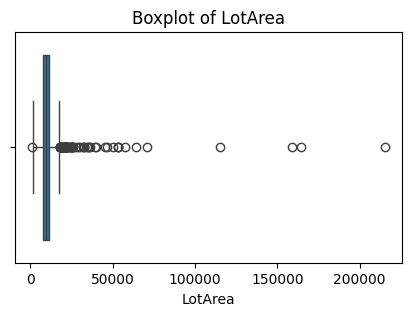

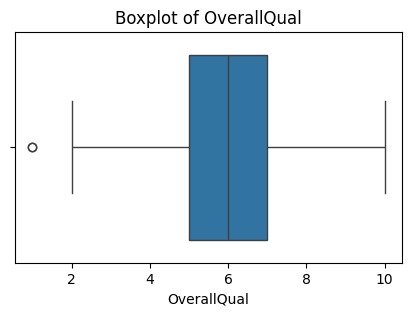

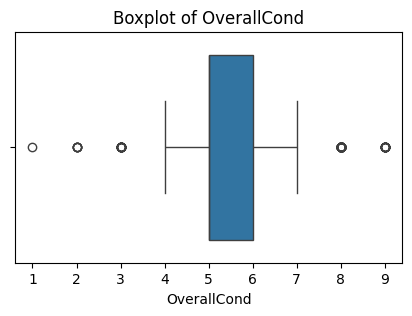

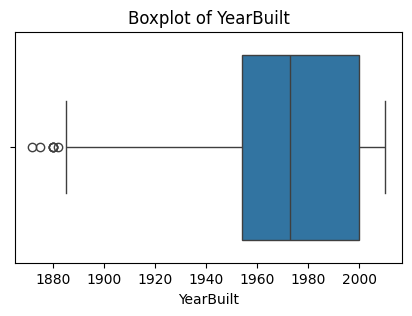

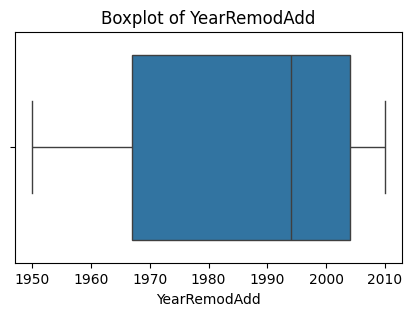

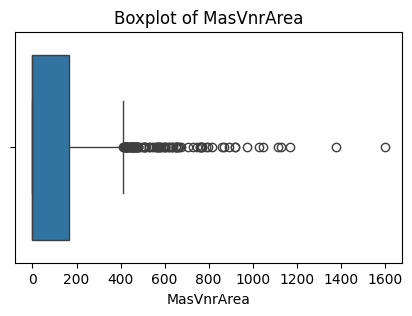

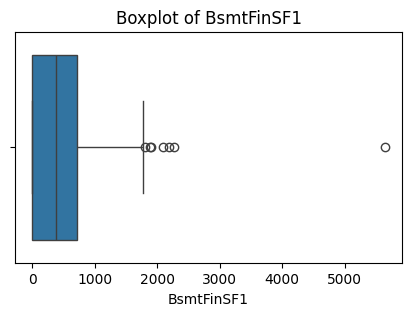

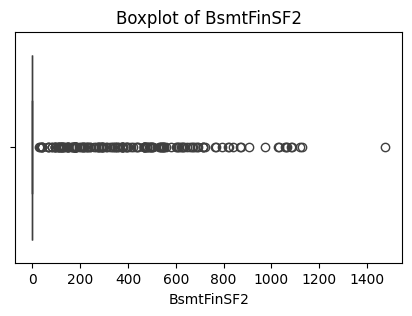

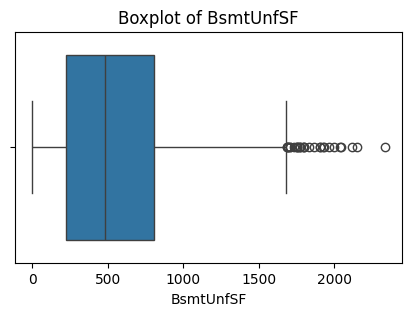

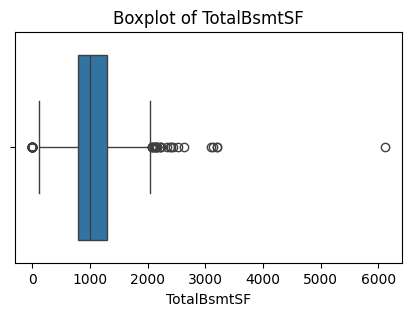

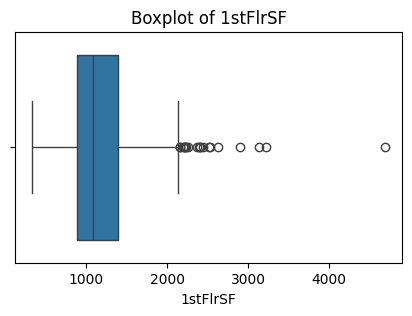

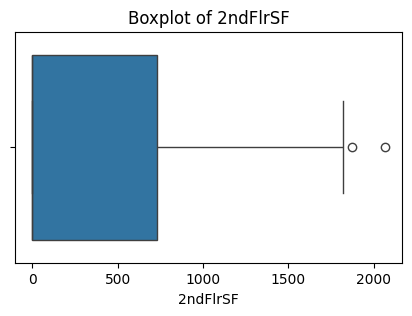

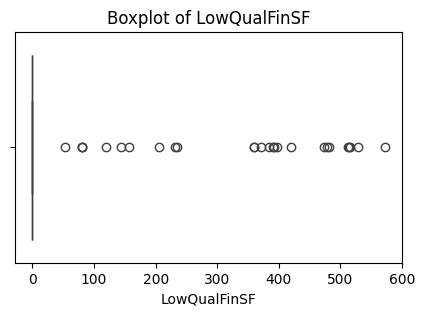

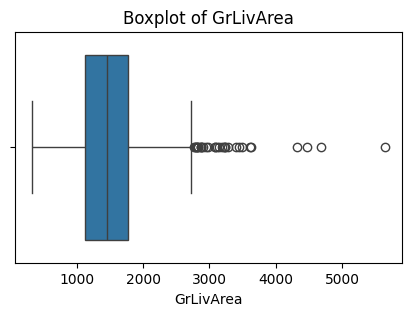

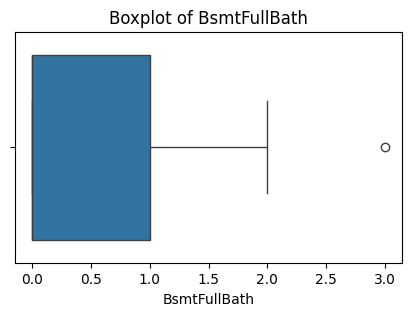

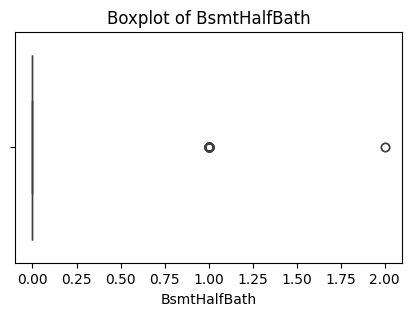

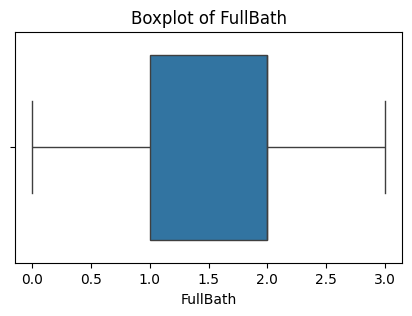

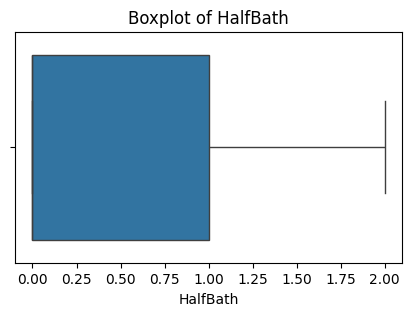

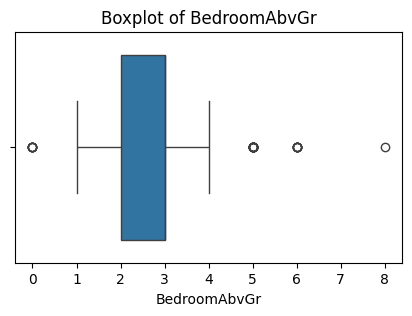

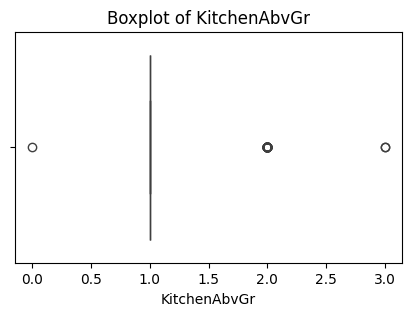

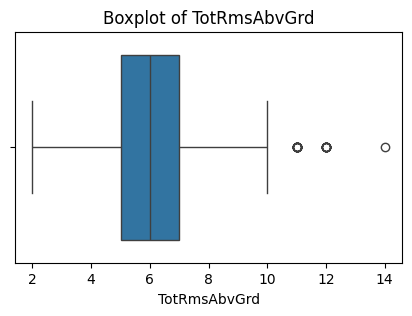

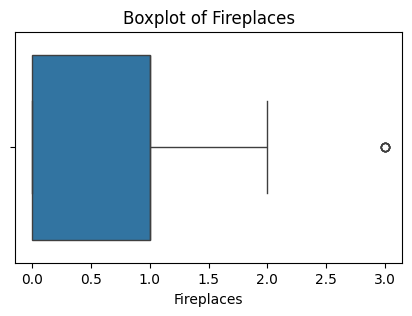

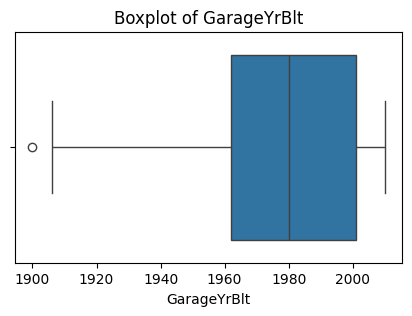

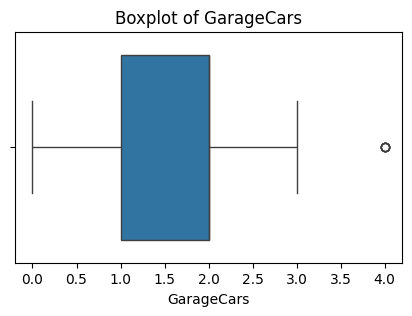

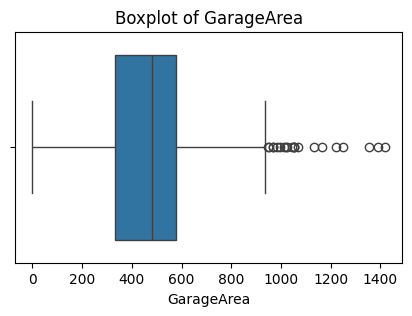

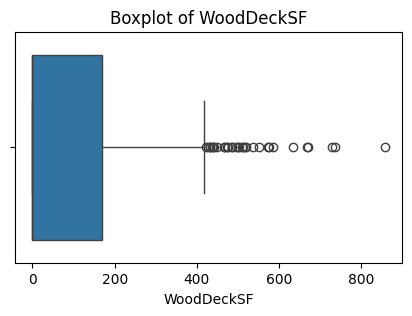

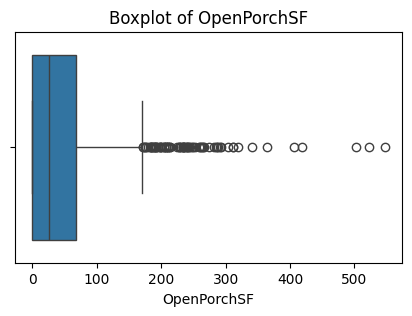

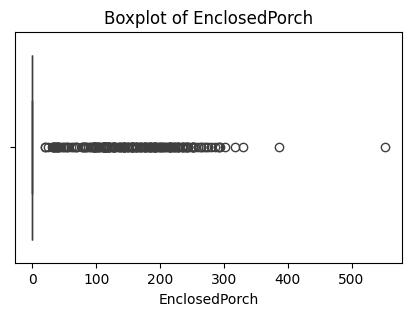

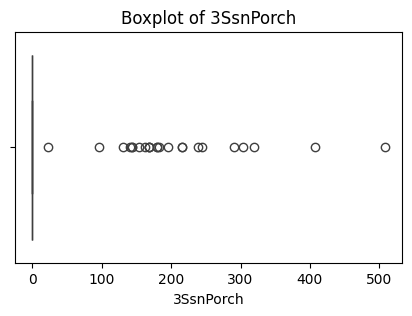

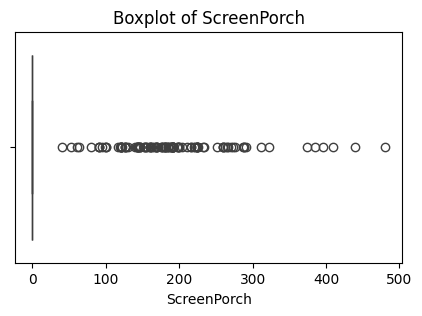

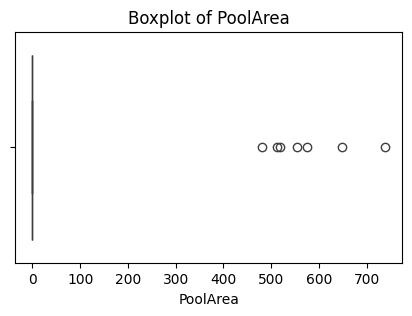

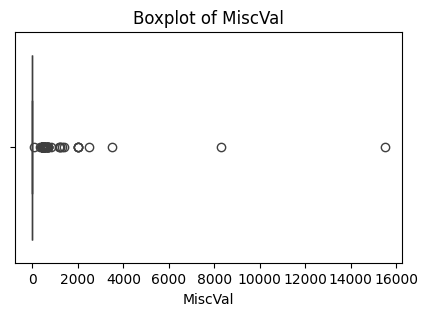

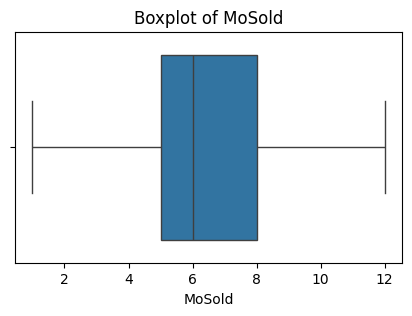

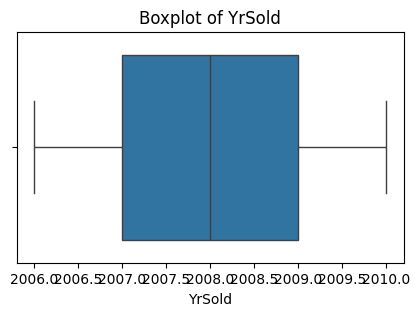

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_outlier(df, num_cols):
    for col in num_cols:
        plt.figure(figsize=(5,3))
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col}')
        plt.show()

visualize_outlier(X_train, numerical_cols)

In [76]:
def outlier_handling(df, numerical_cols, lower_pct=0.01, upper_pct=0.99):
    df = df.copy()

    for col in numerical_cols:
        lower_bound = df[col].quantile(lower_pct)
        upper_bound = df[col].quantile(upper_pct)
        mask_outlier = (df[col] < lower_bound) | (df[col] > upper_bound)
        outlier_indices = df[mask_outlier].index

        if len(outlier_indices) <= 2 and len(outlier_indices) > 0:
            df = df.drop(outlier_indices)

    return df

# Only apply on train dataset.
X_train_clean = outlier_handling(X_train, numerical_cols)
y_train_clean = y_train.loc[X_train_clean.index]

<!-- # **Preprocessing** -->

In [77]:
# Split train - validation. Dataset doesnt have ground truth.
X_train, X_val, y_train, y_val = train_test_split(X_train_clean, y_train_clean, test_size=0.2, random_state=42)

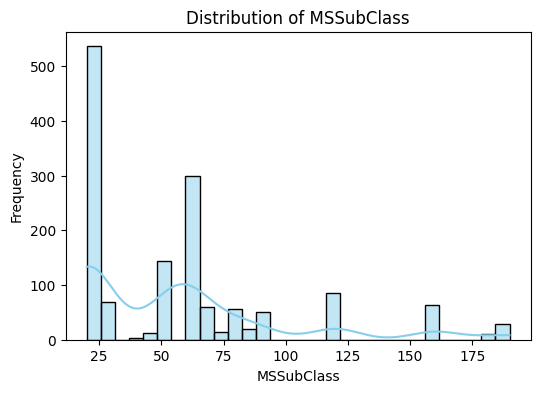

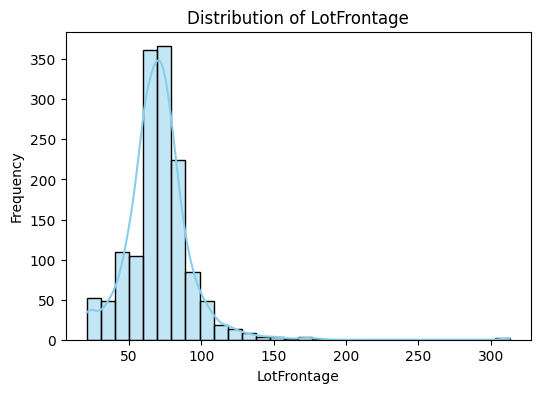

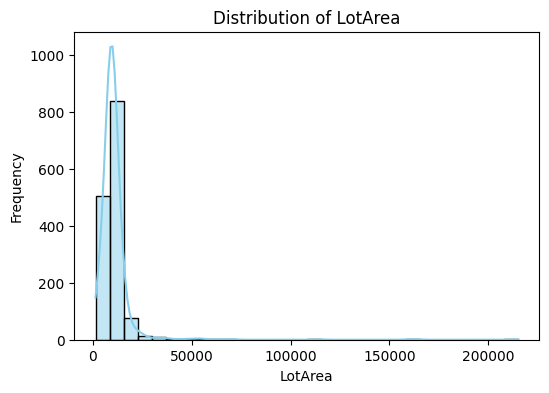

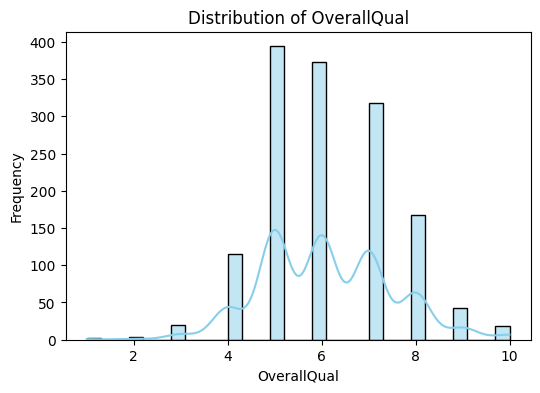

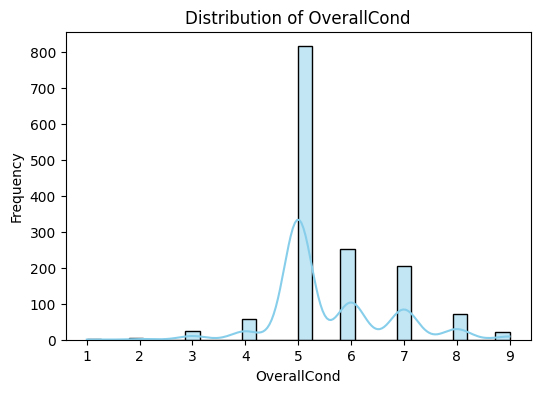

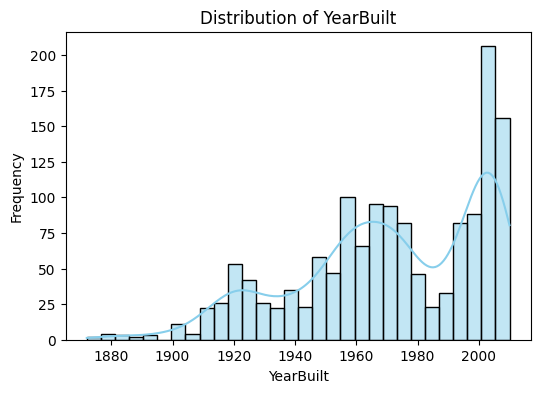

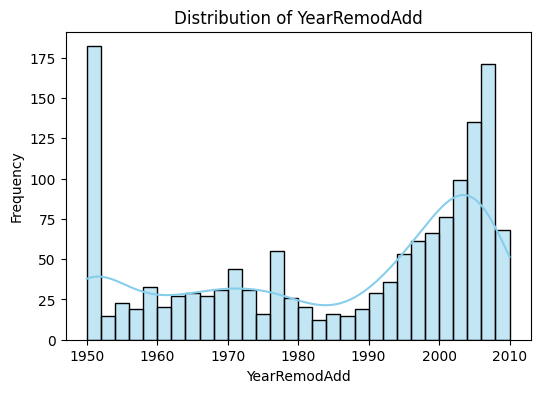

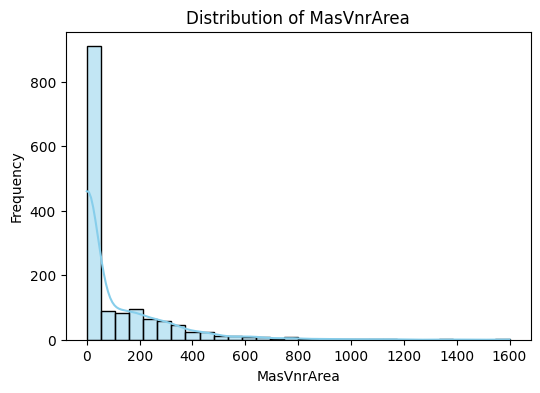

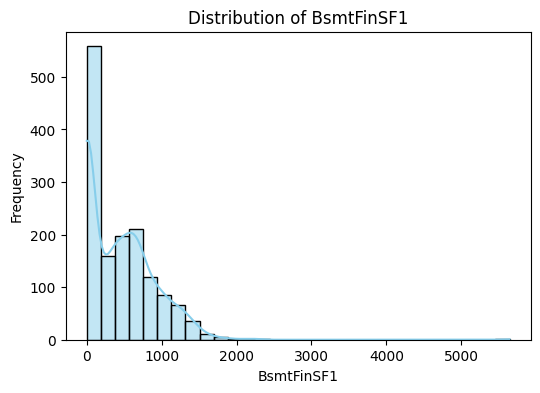

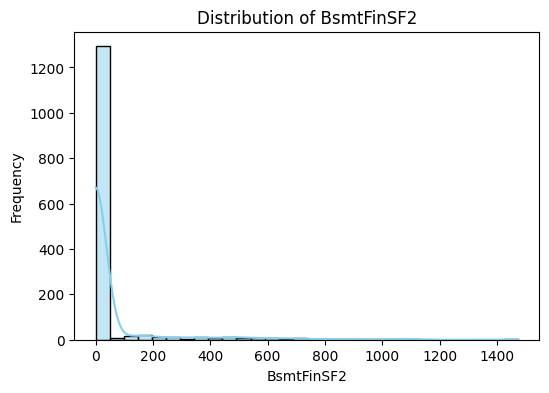

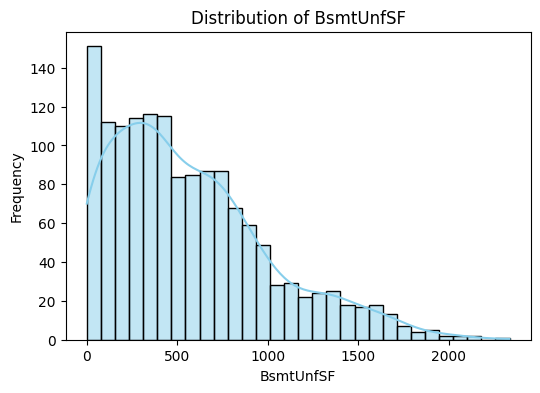

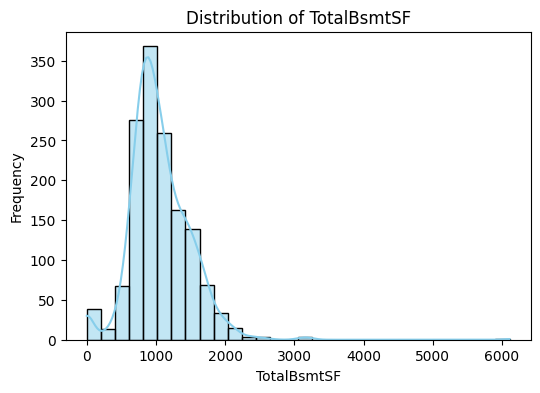

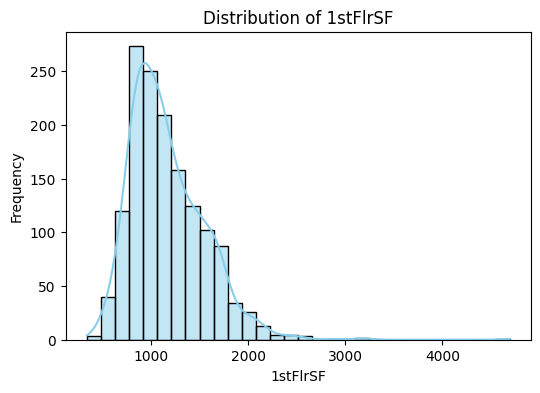

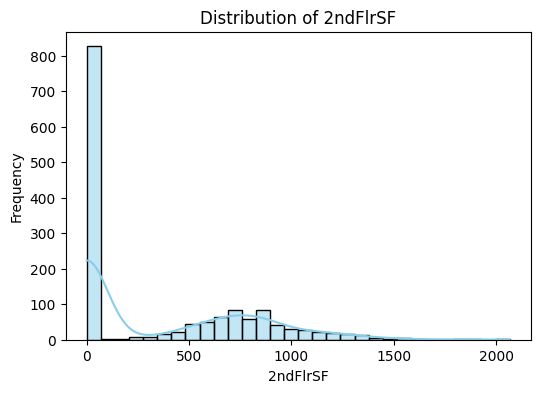

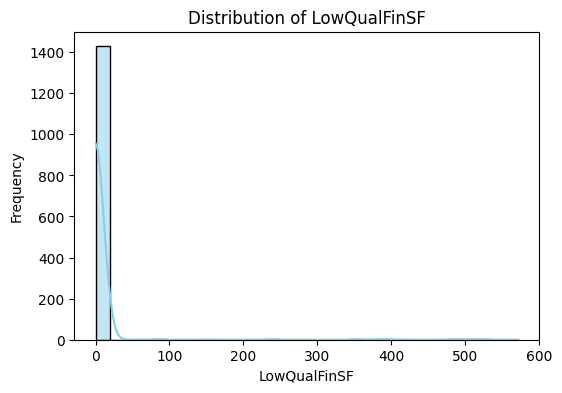

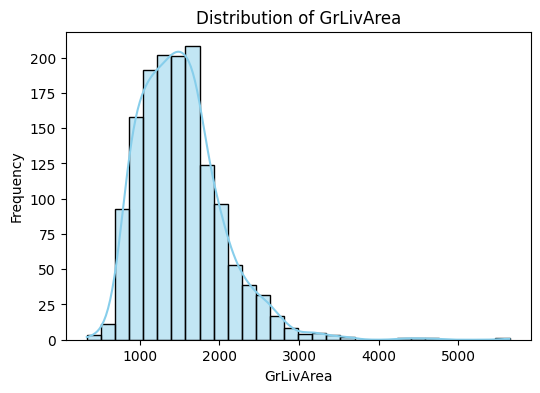

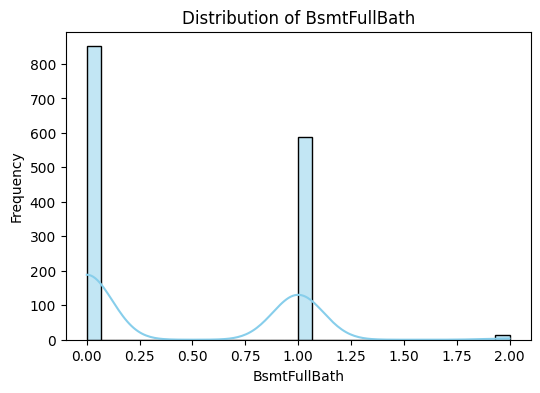

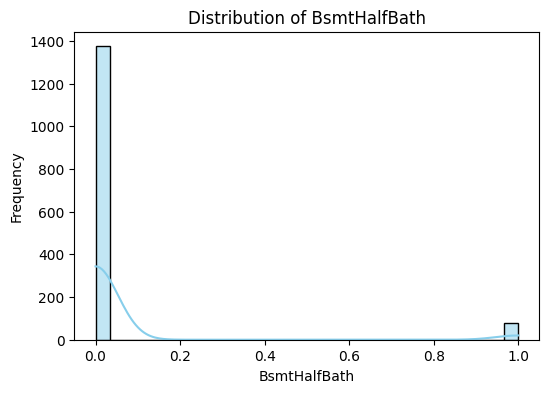

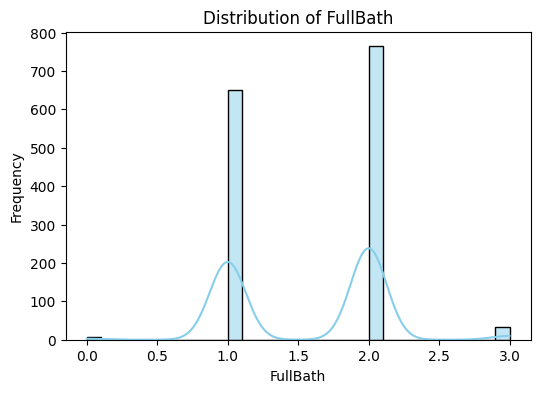

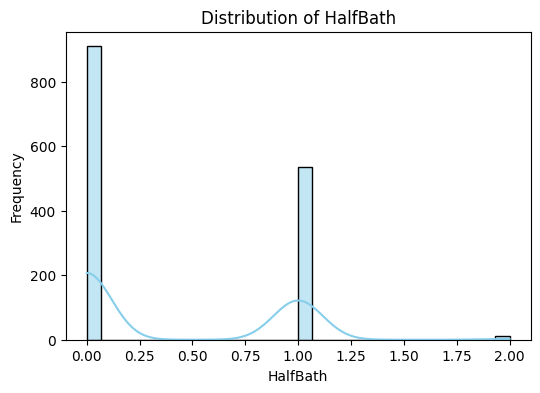

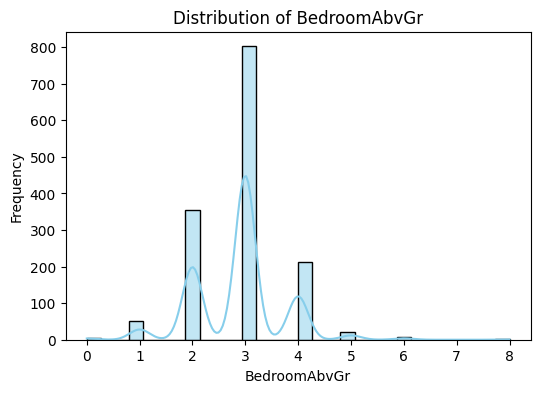

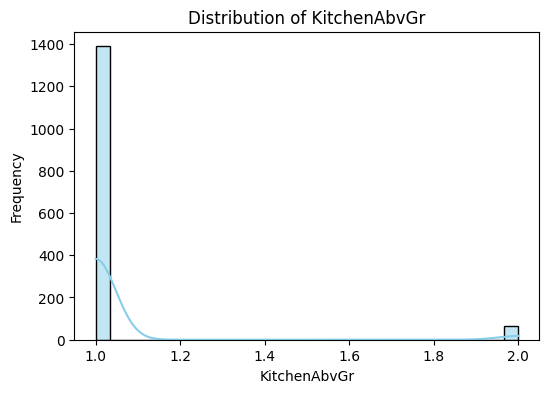

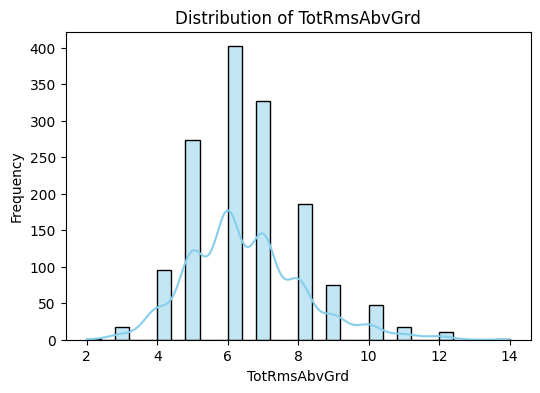

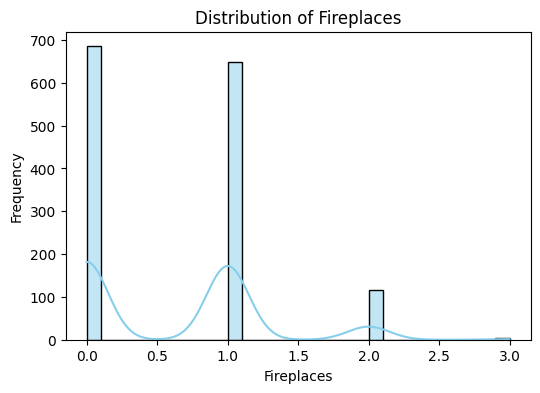

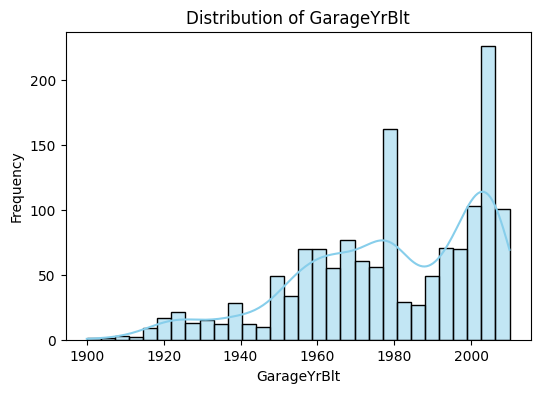

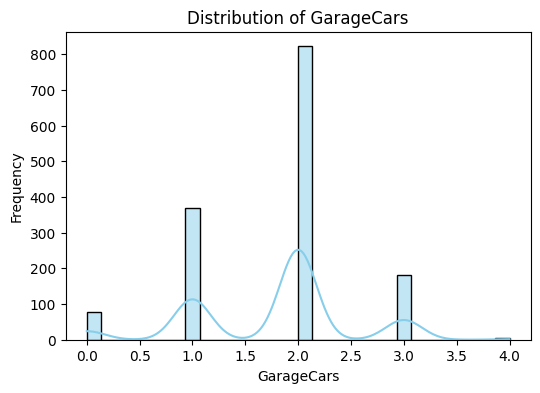

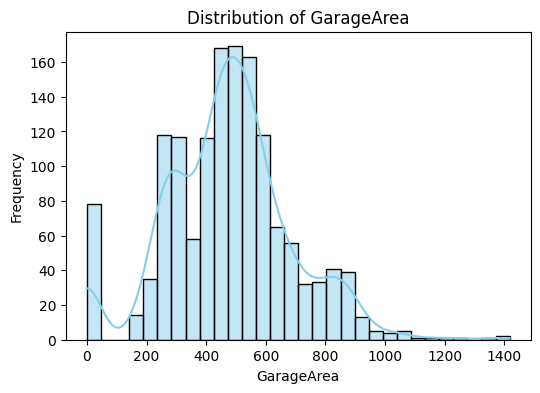

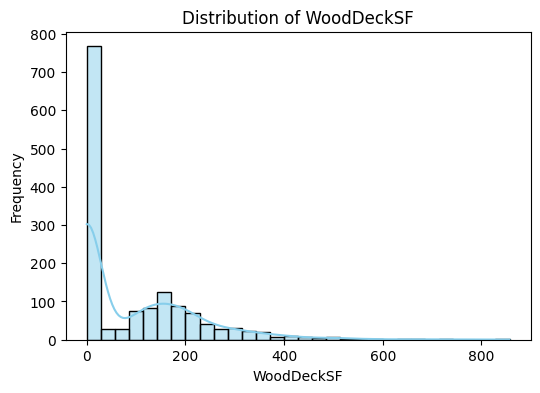

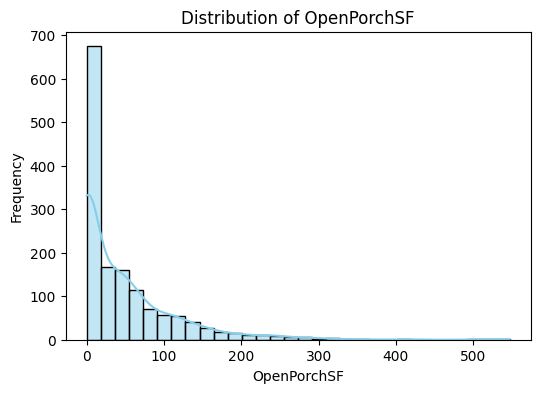

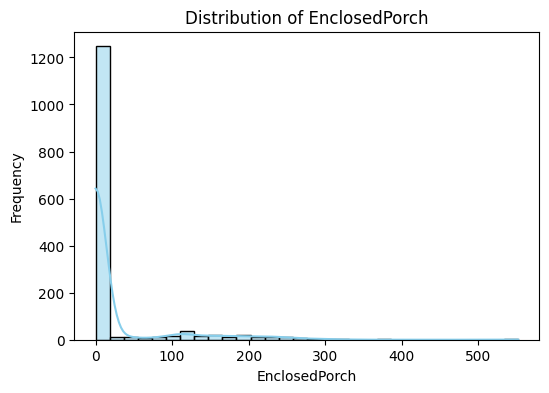

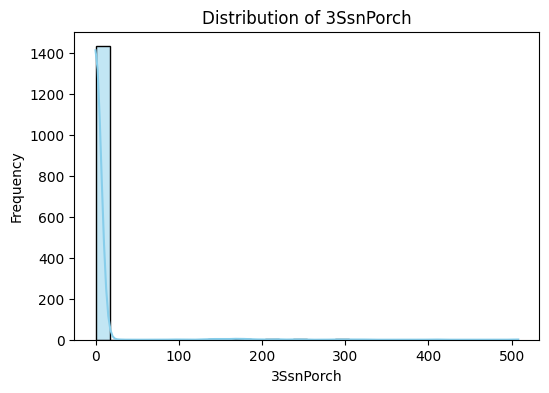

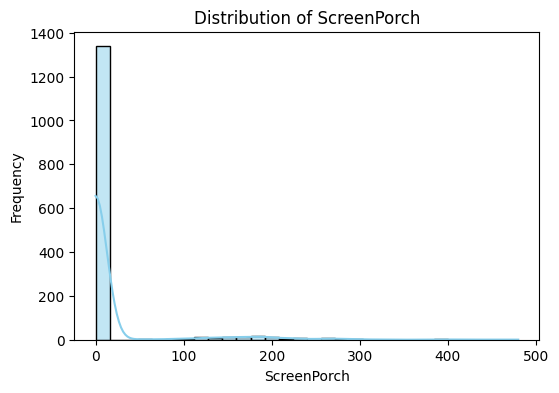

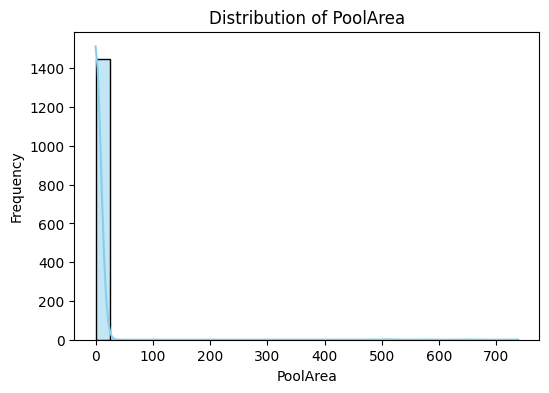

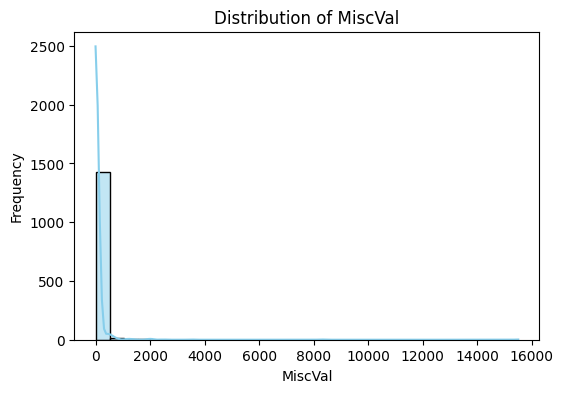

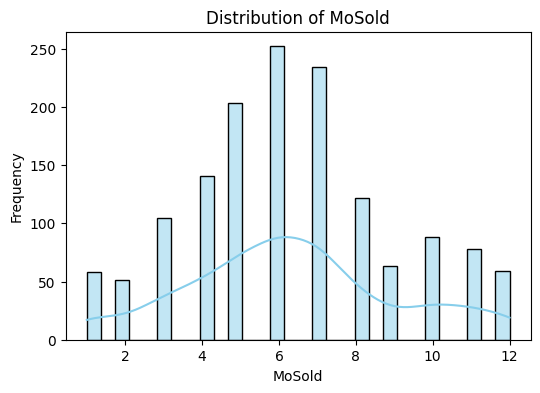

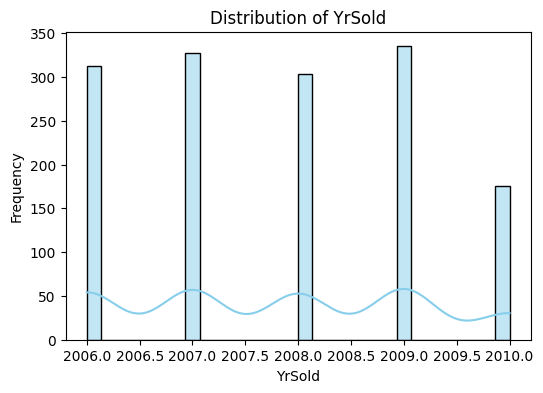

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_distribution(df, num_cols):
    for col in num_cols:
        plt.figure(figsize=(6,4))
        sns.histplot(df[col], kde=True, bins=30, color='skyblue')
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()

visualize_distribution(X_train_clean, numerical_cols)

In [78]:
def check_skew(df, num_cols):
    df = df.copy()
    skew_right_cols, skew_left_cols = [], []

    for col in num_cols:
        skew_val = df[col].skew()
        if skew_val > 1:
            skew_right_cols.append(col)
        elif skew_val < -1:
            skew_left_cols.append(col)
    return skew_right_cols, skew_left_cols

skew_right_cols, skew_left_cols = check_skew(X_train_clean, numerical_cols)

In [46]:
# transformer = ColumnTransformer([
#     ('transform_right', FunctionTransformer(np.log1p, validate=False, feature_names_out='one-to-one'), skew_right_cols),
#     ('transform_left', FunctionTransformer(lambda x: np.log1p(max(x) - x), validate=False), skew_left_cols)
# ], remainder='passthrough')

In [79]:
# Numerical transformer.
numerical_transformer = Pipeline(steps=[
    ('distribution_normalizer', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler())
])

# Categorical_transformer
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [80]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical_transformer', numerical_transformer, numerical_cols),
        ('categorical_transformer', categorical_transformer, categorical_cols)
    ],
    remainder='drop'
)

In [49]:
# # Numerical transformer.
# numeric_transformer = Pipeline(steps=[
#     ('distribution_normalizer', PowerTransformer(method='yeo-johnson')),
#     ('scaler', StandardScaler())
# ])

# # Categorical transformer.
# ordinal_cols = [
#     'LotShape', 'LandSlope', 'ExterQual', 'ExterCond',
#     'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
#     'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu',
#     'GarageQual', 'GarageCond', 'PoolQC', 'Fence'
# ]
# ordinal_categories = [
#     ['Reg', 'IR1', 'IR2', 'IR3'],               # LotShape
#     ['Sev', 'Mod', 'Gtl'],                      # LandSlope
#     ['Po', 'Fa', 'TA', 'Gd', 'Ex'],             # ExterQual
#     ['Po', 'Fa', 'TA', 'Gd', 'Ex'],             # ExterCond
#     ['N/A','Po', 'Fa', 'TA', 'Gd', 'Ex'],       # BsmtQual
#     ['N/A','Po', 'Fa', 'TA', 'Gd', 'Ex'],       # BsmtCond
#     ['N/A','No', 'Mn', 'Av', 'Gd'],             # BsmtExposure
#     ['N/A','Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # BsmtFinType1
#     ['N/A','Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # BsmtFinType2
#     ['Po', 'Fa', 'TA', 'Gd', 'Ex'],             # HeatingQC
#     ['Po', 'Fa', 'TA', 'Gd', 'Ex'],             # KitchenQual
#     ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],  # Functional
#     ['N/A','Po', 'Fa', 'TA', 'Gd', 'Ex'],       # FireplaceQu
#     # ['Unf', 'RFn', 'Fin'],                      # GarageFinish
#     ['N/A','Po', 'Fa', 'TA', 'Gd', 'Ex'],       # GarageQual
#     ['N/A','Po', 'Fa', 'TA', 'Gd', 'Ex'],       # GarageCond
#     # ['N', 'P', 'Y'],                            # PavedDrive
#     ['N/A','Fa', 'TA', 'Gd', 'Ex'],             # PoolQC
#     ['N/A','MnWw', 'GdWo', 'MnPrv', 'GdPrv']    # Fence
# ]
# nominal_cols = [
#     'Utilities', 'GarageFinish', 'MSZoning', 'Street', 'Alley', 'LandContour',
#     'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
#     'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
#     'Heating', 'CentralAir', 'Electrical', 'GarageType', 'MiscFeature',
#     'SaleType', 'SaleCondition', 'LotConfig', 'Neighborhood', 'PavedDrive'
# ]
# nominal_transformer = OneHotEncoder(handle_unknown='ignore')
# ordinal_transformer = OrdinalEncoder(categories=ordinal_categories)

In [50]:
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('numerical_transformer', numeric_transformer, numerical_cols),
#         ('nominal_transformer', nominal_transformer, nominal_cols),
#         ('ordinal_transformer', ordinal_transformer, ordinal_cols)
#     ],
#     remainder='drop'
# )

In [81]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

<!-- # **Train dan Evaluasi Normal** -->

In [82]:
model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numerical_transformer', ...), ('categorical_transformer', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [83]:
y_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"R-squared (R2): {r2:.3f}")
print(f"Mean Squared Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {mse**0.5:.3f}")

R-squared (R2): 0.814
Mean Squared Error (MAE): 19850.773
Mean Squared Error (MSE): 983581132.146
Root Mean Squared Error (RMSE): 31362.097


In [84]:
feature_importance = pd.DataFrame({
    'feature': model.named_steps['preprocessor'].get_feature_names_out(),
    'coefficients': model.named_steps['regressor'].coef_
})

feature_importance = feature_importance.sort_values(by='coefficients', ascending=False)
feature_importance

,feature,coefficients
130,categorical_transformer__RoofMatl_WdShngl,138399.930668
269,categorical_transformer__PoolQC_Ex,128721.158636
126,categorical_transformer__RoofMatl_Metal,84124.139464
129,categorical_transformer__RoofMatl_WdShake,77723.313814
125,categorical_transformer__RoofMatl_CompShg,65732.449606
...,...,...
271,categorical_transformer__PoolQC_Gd,-64035.707825
282,categorical_transformer__MiscFeature_TenC,-64148.481450
270,categorical_transformer__PoolQC_Fa,-64148.481450
101,categorical_transformer__Condition2_PosN,-144837.623825


<!-- # **Train dan Evaluasi dengan Tracking MLflow** -->

In [85]:
TRACKING_URI = "sqlite:///mlflow.db"
EXPERIMENT_NAME = "house_price_prediction"
REGISTERED_MODEL_PREFIX = "house_price_prediction"

In [86]:
mlflow.set_tracking_uri(TRACKING_URI)
# mlflow.create_experiment(EXPERIMENT_NAME)
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location=('file:///c:/Users/ansha/Documents/DibimbingAssignment/Assignment_MLOPS_Rifqi '
 'Anshari Rasyid/notebooks/mlruns/1'), creation_time=1762242131677, experiment_id='1', last_update_time=1762242131677, lifecycle_stage='active', name='house_price_prediction', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [87]:
# Helper func. evaluation
def evaluate_model(y_val, y_pred):
    return {
        'r2': r2_score(y_val, y_pred),
        'mae': mean_absolute_error(y_val, y_pred),
        'mse': mean_squared_error(y_val, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_val, y_pred))
    }

In [88]:
# Multiple models config.
models_config = {
    'linear_regression': {
        'model': LinearRegression(),
        'params': {
            'fit_intercept': True
        }
    },
    'ridge_regression': {
        'model': Ridge(),
        'params': {
            'alpha': 1.0,
            'fit_intercept': True,
            'solver': 'auto',
            'random_state': 42
        }
    },
    'lasso_regression': {
        'model': Lasso(),
        'params': {
            'alpha': 0.1,
            'fit_intercept': True,
            'max_iter': 1000,
            'random_state': 42
        }
    },
    'elastic_net': {
        'model': ElasticNet(),
        'params': {
            'alpha': 0.1,
            'l1_ratio': 0.5,
            'fit_intercept': True,
            'max_iter': 1000,
            'random_state': 42
        }
    },
    'random_forest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': 100,
            'max_depth': None,
            'min_samples_split': 2,
            'random_state': 42
        }
    },
    'gradient_boosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': 100,
            'learning_rate': 0.1,
            'max_depth': 3,
            'random_state': 42
        }
    }
}

In [89]:
for name, info in models_config.items():
    with mlflow.start_run(run_name=name):
        instance_model = info['model']
        instance_model.set_params(**info['params'])
        # model = type(info['model'])(**info['params'])
        model = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', instance_model)
        ])
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        # r2 = r2_score(y_val, y_pred)
        # mse = mean_squared_error(y_val, y_pred)
        # rmse = mse ** 0.5
        metrics = evaluate_model(y_val, y_pred)
        mlflow.log_metrics(metrics)

        mlflow.log_params(info['params'])
        mlflow.sklearn.log_model(model, name, registered_model_name=f"{REGISTERED_MODEL_PREFIX}_{name}")
        
        regressor = model.named_steps['regressor']
        if hasattr(regressor, "coef_"):
            importance_values = regressor.coef_
        elif hasattr(regressor, "feature_importances_"):
            importance_values = regressor.feature_importances_
        else:
            importance_values = None

        feature_importance = pd.DataFrame({
            'feature': model.named_steps['preprocessor'].get_feature_names_out(),
            'coefficients/importance': importance_values
        })

        feature_importance.to_csv(f"feature_importance_trained/feature_importance_{name}.csv", index=False)
        mlflow.log_artifact(f"feature_importance_trained/feature_importance_{name}.csv")

        print(f"\nModel: {name}")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.3f}")

2025/11/07 00:36:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/07 00:36:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'house_price_prediction_linear_regression' already exists. Creating a new version of this model...
Created version '4' of model 'house_price_prediction_linear_regression'.



Model: linear_regression
r2: 0.814
mae: 19850.773
mse: 983581132.146
rmse: 31362.097


2025/11/07 00:36:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/07 00:36:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'house_price_prediction_ridge_regression' already exists. Creating a new version of this model...
Created version '3' of model 'house_price_prediction_ridge_regression'.



Model: ridge_regression
r2: 0.858
mae: 19008.027
mse: 750505051.787
rmse: 27395.347


2025/11/07 00:36:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/07 00:36:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'house_price_prediction_lasso_regression' already exists. Creating a new version of this model...
Created version '3' of model 'house_price_prediction_lasso_regression'.



Model: lasso_regression
r2: 0.828
mae: 19289.519
mse: 908902587.536
rmse: 30148.011


2025/11/07 00:36:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/07 00:36:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'house_price_prediction_elastic_net' already exists. Creating a new version of this model...
Created version '3' of model 'house_price_prediction_elastic_net'.



Model: elastic_net
r2: 0.885
mae: 17263.123
mse: 608523774.840
rmse: 24668.275


2025/11/07 00:36:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/07 00:37:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'house_price_prediction_random_forest' already exists. Creating a new version of this model...
Created version '3' of model 'house_price_prediction_random_forest'.



Model: random_forest
r2: 0.887
mae: 16311.463
mse: 594849081.451
rmse: 24389.528


2025/11/07 00:37:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/07 00:37:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Model: gradient_boosting
r2: 0.911
mae: 15122.119
mse: 468076558.990
rmse: 21635.077


Registered model 'house_price_prediction_gradient_boosting' already exists. Creating a new version of this model...
Created version '3' of model 'house_price_prediction_gradient_boosting'.


In [90]:
def get_all_runs_df():
    experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
    runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
    return runs

df_runs = get_all_runs_df()
df_runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.r2,metrics.rmse,metrics.mae,metrics.mse,...,params.min_samples_split,params.l1_ratio,params.alpha,params.max_iter,params.fit_intercept,params.solver,tags.mlflow.runName,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type
0,b9c0d9ac70814766a92556bbc6adab99,1,FINISHED,file:///c:/Users/ansha/Documents/DibimbingAssi...,2025-11-06 17:37:00.498000+00:00,2025-11-06 17:37:06.189000+00:00,0.911287,21635.077051,15122.119204,4.680766e+08,...,None,None,None,None,None,None,gradient_boosting,c:\Users\ansha\Documents\DibimbingAssignment\A...,ansha,LOCAL
1,d51e94e4834e4aee895aaf14e4cb6200,1,FINISHED,file:///c:/Users/ansha/Documents/DibimbingAssi...,2025-11-06 17:36:44.750000+00:00,2025-11-06 17:37:00.469000+00:00,0.887260,24389.528110,16311.463471,5.948491e+08,...,2,None,None,None,None,None,random_forest,c:\Users\ansha\Documents\DibimbingAssignment\A...,ansha,LOCAL
2,bf47547e03664f25a75fc5e915e799aa,1,FINISHED,file:///c:/Users/ansha/Documents/DibimbingAssi...,2025-11-06 17:36:40.302000+00:00,2025-11-06 17:36:44.733000+00:00,0.884669,24668.274663,17263.123060,6.085238e+08,...,None,0.5,0.1,1000,True,None,elastic_net,c:\Users\ansha\Documents\DibimbingAssignment\A...,ansha,LOCAL
3,83035b6bf0af46ea986c4013a4c8751b,1,FINISHED,file:///c:/Users/ansha/Documents/DibimbingAssi...,2025-11-06 17:36:35.570000+00:00,2025-11-06 17:36:40.286000+00:00,0.827739,30148.011336,19289.519093,9.089026e+08,...,None,None,0.1,1000,True,None,lasso_regression,c:\Users\ansha\Documents\DibimbingAssignment\A...,ansha,LOCAL
4,58f4ebc0ab264e69a391b771077ae368,1,FINISHED,file:///c:/Users/ansha/Documents/DibimbingAssi...,2025-11-06 17:36:31.089000+00:00,2025-11-06 17:36:35.553000+00:00,0.857759,27395.347265,19008.027444,7.505051e+08,...,None,None,1.0,None,True,auto,ridge_regression,c:\Users\ansha\Documents\DibimbingAssignment\A...,ansha,LOCAL
5,26014fd096aa4bd99a0b13959298999a,1,FINISHED,file:///c:/Users/ansha/Documents/DibimbingAssi...,2025-11-06 17:36:26.048000+00:00,2025-11-06 17:36:31.050000+00:00,0.813585,31362.097062,19850.773198,9.835811e+08,...,None,None,None,None,True,None,linear_regression,c:\Users\ansha\Documents\DibimbingAssignment\A...,ansha,LOCAL
6,aa55998d60264ef5b0dc2fd94265ba90,1,FINISHED,file:///c:/Users/ansha/Documents/DibimbingAssi...,2025-11-06 17:24:44.397000+00:00,2025-11-06 17:24:50.042000+00:00,0.911287,21635.077051,15122.119204,4.680766e+08,...,None,None,None,None,None,None,gradient_boosting,c:\Users\ansha\Documents\DibimbingAssignment\A...,ansha,LOCAL
7,3efa970eb35f48e7a011f2f89696cdf8,1,FINISHED,file:///c:/Users/ansha/Documents/DibimbingAssi...,2025-11-06 17:24:27.153000+00:00,2025-11-06 17:24:44.372000+00:00,0.887260,24389.528110,16311.463471,5.948491e+08,...,2,None,None,None,None,None,random_forest,c:\Users\ansha\Documents\DibimbingAssignment\A...,ansha,LOCAL
8,4791de7b2f144cb6acfbb7965eeb5697,1,FINISHED,file:///c:/Users/ansha/Documents/DibimbingAssi...,2025-11-06 17:24:22.417000+00:00,2025-11-06 17:24:27.118000+00:00,0.884669,24668.274663,17263.123060,6.085238e+08,...,None,0.5,0.1,1000,True,None,elastic_net,c:\Users\ansha\Documents\DibimbingAssignment\A...,ansha,LOCAL
9,8e7bc18548c84ab195f93cb5a39dca2d,1,FINISHED,file:///c:/Users/ansha/Documents/DibimbingAssi...,2025-11-06 17:24:17.420000+00:00,2025-11-06 17:24:22.399000+00:00,0.827739,30148.011336,19289.519093,9.089026e+08,...,None,None,0.1,1000,True,None,lasso_regression,c:\Users\ansha\Documents\DibimbingAssignment\A...,ansha,LOCAL


In [91]:
metrics_comparison = df_runs[['tags.mlflow.runName', 'metrics.r2', 'metrics.mse', 'metrics.rmse']].sort_values('metrics.r2', ascending=False)
metrics_comparison  # Sorted descending based on R2.

,tags.mlflow.runName,metrics.r2,metrics.mse,metrics.rmse
0,gradient_boosting,0.911287,4.680766e+08,21635.077051
6,gradient_boosting,0.911287,4.680766e+08,21635.077051
13,gradient_boosting,0.908034,4.852420e+08,22028.208334
14,random_forest,0.890634,5.770483e+08,24021.829980
1,random_forest,0.887260,5.948491e+08,24389.528110
7,random_forest,0.887260,5.948491e+08,24389.528110
15,elastic_net,0.884840,6.076218e+08,24649.985195
2,elastic_net,0.884669,6.085238e+08,24668.274663
8,elastic_net,0.884669,6.085238e+08,24668.274663
10,ridge_regression,0.857759,7.505051e+08,27395.347265


In [92]:
best_model_run_name = metrics_comparison.iloc[0]['tags.mlflow.runName']
best_model_r2_score = metrics_comparison.iloc[0]['metrics.r2']
best_model_mse_score = metrics_comparison.iloc[0]['metrics.mse']
best_model_rmse_score = metrics_comparison.iloc[0]['metrics.rmse']

print(f"Best model (based on R2 score): {best_model_run_name}")
print(f"R-squared (R2): {best_model_r2_score:.3f}")
print(f"Mean Squared Error (MSE): {best_model_mse_score:.3f}")
print(f"Root Mean Squared Error (RMSE): {best_model_rmse_score:.3f}")

Best model (based on R2 score): gradient_boosting
R-squared (R2): 0.911
Mean Squared Error (MSE): 468076558.990
Root Mean Squared Error (RMSE): 21635.077


In [93]:
# Version and stage status.
versions = mlflow.search_model_versions(filter_string=f"run_id='f644a60468b64c4eaa2998fa297ec937'")
for version in versions:
    print(f"version {version.version}, run_id: {version.run_id}, stage: {version.current_stage}")

version 1, run_id: f644a60468b64c4eaa2998fa297ec937, stage: Production


In [66]:
client = MlflowClient()

In [67]:
def transition_model_to_production(client, model_name):
    # latest_version = client.get_latest_versions(f"{REGISTERED_MODEL_PREFIX}_{model_name}", stages=["None"])[0]
    # client.transition_model_version_stage(
    #     name=f"{REGISTERED_MODEL_PREFIX}_{model_name}",
    #     version=latest_version.version,
    #     stage="Production"
    # )
    
    client.transition_model_version_stage(
        name=f"{REGISTERED_MODEL_PREFIX}_{model_name}",
        version=1,
        stage="Production"
    )

transition_model_to_production(client, "linear_regression")

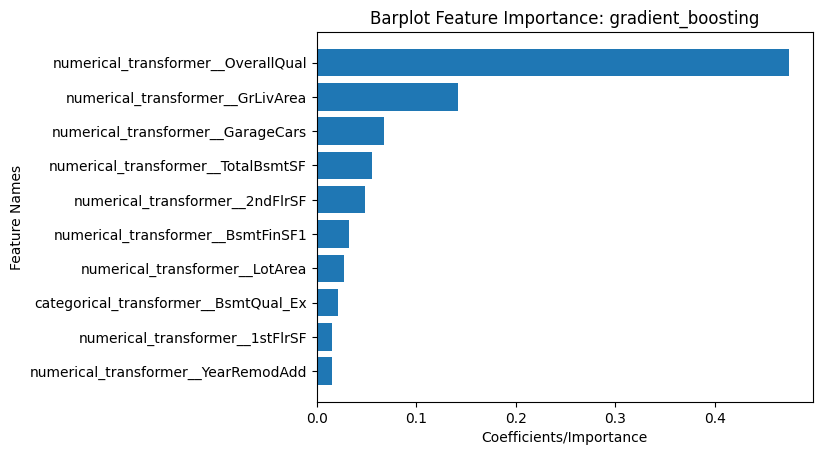

In [ ]:
# df = pd.read_csv(f"feature_importance_{best_model_run_name}.csv")
# top_10_features = df.sort_values(by='coefficients/importance', ascending=False).head(10)

# plt.barh(top_10_features[::-1]['feature'], top_10_features[::-1]['coefficients/importance'])
# plt.xlabel('Coefficients/Importance')
# plt.ylabel('Feature Names')
# plt.title(f'Barplot Feature Importance: {best_model_run_name}')
# plt.show()

In [ ]:
# EOL